In [1]:
import numpy as np
import pandas as pd
import pickle, csv
import os

from keras.models import Sequential, load_model, Model
from keras.layers import LSTM, Dense, Dropout, Input, concatenate, Flatten, Reshape,MaxPooling2D, Conv2D, TimeDistributed, BatchNormalization
from keras import regularizers
from keras.utils import to_categorical

from keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.sequence import TimeseriesGenerator
import tensorflow.keras.backend as K
from skimage.transform import resize
from tensorflow.keras import layers, models


from matplotlib import pyplot as plt
from matplotlib import style
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
import seaborn as sns

import datetime

import tensorflow.keras.backend as K
K.clear_session()

In [2]:
# Load powerprice data and format it
df_powerprice = pd.read_csv("data/PowerPrice.csv")
df_powerprice["Time"] = pd.to_datetime(df_powerprice["Time"], infer_datetime_format=True)
df_powerprice = df_powerprice.drop(columns=["Time"])
df_powerprice

,DayAhead,Spot,REBAP
0,2.83200,3.688,-4.566
1,2.37575,4.245,-13.964
2,1.91950,3.161,0.345
3,1.46325,1.664,3.048
4,1.00700,3.110,-6.679
...,...,...,...
35035,3.77625,3.342,4.856
35036,3.73900,4.425,8.561
35037,3.70175,2.473,6.076
35038,3.66450,3.241,11.797


In [3]:
# Load spatial data and format it
datasets = []
for filename in os.listdir("data/Spatial"):
    if filename.endswith(".pickle"):
        with open(os.path.join("data/Spatial", filename), "rb") as file:
            data = pickle.load(file)
            if data.shape == (100, 35040):
                datasets.append(data)
                print(filename)
            else:
                print(f"Skipping {filename}: unexpected shape {data.shape}")

biogas_kw_2019.pickle
brown_coal_kw_2019.pickle
completed_solar_kw_2019.pickle
completed_wind_onshore_kw_2019.pickle
demand_kw_2019.pickle
hard_coal_kw_2019.pickle
nuclear_kw_2019.pickle
oil_kw_2019.pickle
water_laufwasser_kw_2019.pickle
water_pumpspeicher_PB_kw_2019.pickle
water_pumpspeicher_TB_kw_2019.pickle
water_speicherwasser_kw_2019.pickle
wind_offshore_kw_2019.pickle


In [4]:
# Convert the list of arrays to a 3D array
spatial_data = np.stack(datasets, axis=0)

spatial_data = spatial_data.reshape((spatial_data.shape[0], spatial_data.shape[1], spatial_data.shape[2]))

# Transpose the second and third dimensions to get shape (13, 35040, 100)
spatial_data = spatial_data.transpose((0, 1, 2))

spatial_data.shape

(13, 100, 35040)

In [5]:
# Load mask and reshape to match desired output shape
mask = pd.read_csv("germany/mask.csv", header=None).values
#mask = mask_df.values.reshape((40, 40, 1))

mask.shape

(30, 30)

In [6]:
spatial_data.shape

(13, 100, 35040)

In [7]:
image_all = np.zeros((35040, 30, 30, 13))
for j in range(spatial_data.shape[2]):
    for i in range(spatial_data.shape[0]):
        image = np.zeros((30, 30))
        for s in range(spatial_data.shape[1]):
            image[mask == s] = spatial_data[i, s, j]
        image_all[j, :, :, i] = image

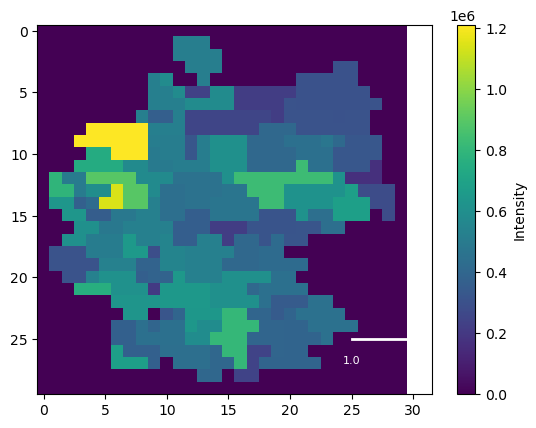

In [8]:
# Plot the specific image with the scale bar
plt.imshow(image_all[35030, :, :, 4])
plt.colorbar(label='Intensity')

scale_value = 1.0  # Specify the value for the scale bar
scale_bar_length = 5  # Specify the length of the scale bar in pixels

plt.plot([25, 25 + scale_bar_length], [25, 25], color='white', linewidth=2)
plt.text(25, 27, f'{scale_value}', color='white', ha='center', fontsize=8)

plt.show()

In [9]:
image_all.shape

(35040, 30, 30, 13)

In [10]:
#input_2 = df_powerprice["DayAhead"].values.reshape((-1, 4))
#input_2.shape

In [11]:
output = df_powerprice["Spot"].values

scaler = MinMaxScaler()
output = scaler.fit_transform(output.reshape(-1, 1))

output

array([[0.34239157],
       [0.34917003],
       [0.33597819],
       ...,
       [0.32760551],
       [0.33695176],
       [0.33731685]])

In [12]:
def split_datasets(df, df2, window_size, look_ahead):
    X = []
    y = []
    for i in range(len(df) - window_size - look_ahead + 1):
        row = df[i:i+window_size, :, :, :]
        X.append(row)
        label = df2[i+window_size+look_ahead-1]
        y.append(label)
    return np.array(X), np.array(y)

In [13]:
window_size = 4
look_ahead = 1
X, y = split_datasets(image_all, output, window_size=window_size, look_ahead=look_ahead)

print(f"X shape: {X.shape}, y shape: {y.shape}")

X shape: (35036, 4, 30, 30, 13), y shape: (35036, 1)


In [14]:
# Reshape the input array to a 2D array
input_2d = X.reshape(-1, X.shape[-1])

# Scale the array using MinMaxScaler
scaler = MinMaxScaler()
input_scaled = scaler.fit_transform(input_2d)

# Reshape the scaled array back to the original shape
X = input_scaled.reshape(X.shape)

print("Scaled X shape:", X.shape)

Scaled X shape: (35036, 4, 30, 30, 13)


In [15]:
# Split the data into train, validation, and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=40)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=40)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (22422, 4, 30, 30, 13)
y_train shape: (22422, 1)
X_val shape: (5606, 4, 30, 30, 13)
y_val shape: (5606, 1)
X_test shape: (7008, 4, 30, 30, 13)
y_test shape: (7008, 1)


In [16]:
time_steps = 4
width = 30
height = 30
channel = 13

# Define the input layer
input_layer = Input(shape=(time_steps, width, height, channel))

# Define the convolutional layers
cnn1 = Conv2D(filters=16, kernel_size=(3, 3))
cnn2 = MaxPooling2D(pool_size=(2, 2))
cnn3 = Conv2D(filters=32, kernel_size=(3, 3))
cnn4 = MaxPooling2D(pool_size=(2, 2))

# Apply TimeDistributed to the convolutional layers
td_cnn1 = TimeDistributed(cnn1)(input_layer)
td_cnn2 = TimeDistributed(cnn2)(td_cnn1)
td_cnn3 = TimeDistributed(cnn3)(td_cnn2)
td_cnn4 = TimeDistributed(cnn4)(td_cnn3)

# Reshape the output of the convolutional layers
reshaped = Reshape((-1, 6*6*32))(td_cnn4)

# Apply TimeDistributed Dense layer
td_fcnn = TimeDistributed(Dense(10))(reshaped)
td_fcnn = BatchNormalization()(td_fcnn)
td_fcnn = LeakyReLU()(td_fcnn)
td_fcnn = Dropout(0.5)(td_fcnn)

# Apply LSTM layers
lstm_output = LSTM(32, return_sequences=True)(td_fcnn)
lstm_output = Dropout(0.5)(lstm_output)
lstm_output = LSTM(16, return_sequences=True)(lstm_output)
lstm_output = Dropout(0.5)(lstm_output)
lstm_output = LSTM(1, return_sequences=False)(lstm_output)

# Create the model
model = Model(inputs=input_layer, outputs=lstm_output)

# Print the model summary
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 4, 30, 30, 13)]   0         
                                                                 
 time_distributed (TimeDistr  (None, 4, 28, 28, 16)    1888      
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 4, 14, 14, 16)    0         
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 4, 12, 12, 32)    4640      
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 4, 6, 6, 32)      0         
 tributed)                                                   

In [17]:
# Compile the model with an appropriate optimizer and loss function
model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

In [18]:
# Define callbacks for early stopping and checkpoint saving
es = EarlyStopping(monitor='val_loss', patience=8, verbose=1, restore_best_weights=True)

In [19]:
today = datetime.datetime.now().strftime("%Y-%m-%d--%H-%M")

In [20]:
cp = ModelCheckpoint(filepath=f"training/model-website/model-{today}.h5", 
                      save_best_only=True,
                      monitor='val_loss', 
                      mode='min', 
                      save_weights_only=False, 
                      verbose=1)

In [21]:
# Fit the model on the training data
history = model.fit(X_train, y_train, batch_size=20, epochs=1000, validation_data=(X_val, y_val), callbacks=[cp, es])

Epoch 1/1000
1118/1122 [============================>.] - ETA: 0s - loss: 0.0207 - root_mean_squared_error: 0.1439
Epoch 1: val_loss improved from inf to 0.00078, saving model to training/model-website\model-2023-09-07--21-00.h5
1122/1122 [==============================] - 16s 10ms/step - loss: 0.0207 - root_mean_squared_error: 0.1438 - val_loss: 7.7896e-04 - val_root_mean_squared_error: 0.0279
Epoch 2/1000
1121/1122 [============================>.] - ETA: 0s - loss: 0.0031 - root_mean_squared_error: 0.0558
Epoch 2: val_loss did not improve from 0.00078
1122/1122 [==============================] - 10s 9ms/step - loss: 0.0031 - root_mean_squared_error: 0.0558 - val_loss: 9.6414e-04 - val_root_mean_squared_error: 0.0311
Epoch 3/1000
1121/1122 [============================>.] - ETA: 0s - loss: 0.0017 - root_mean_squared_error: 0.0417
Epoch 3: val_loss improved from 0.00078 to 0.00058, saving model to training/model-website\model-2023-09-07--21-00.h5
1122/1122 [============================

1117/1122 [============================>.] - ETA: 0s - loss: 2.6462e-04 - root_mean_squared_error: 0.0163
Epoch 24: val_loss improved from 0.00024 to 0.00023, saving model to training/model-website\model-2023-09-07--21-00.h5
1122/1122 [==============================] - 10s 9ms/step - loss: 2.6434e-04 - root_mean_squared_error: 0.0163 - val_loss: 2.2512e-04 - val_root_mean_squared_error: 0.0150
Epoch 25/1000
1118/1122 [============================>.] - ETA: 0s - loss: 2.5264e-04 - root_mean_squared_error: 0.0159
Epoch 25: val_loss improved from 0.00023 to 0.00022, saving model to training/model-website\model-2023-09-07--21-00.h5
1122/1122 [==============================] - 9s 8ms/step - loss: 2.5235e-04 - root_mean_squared_error: 0.0159 - val_loss: 2.2072e-04 - val_root_mean_squared_error: 0.0149
Epoch 26/1000
1117/1122 [============================>.] - ETA: 0s - loss: 2.5032e-04 - root_mean_squared_error: 0.0158
Epoch 26: val_loss did not improve from 0.00022
1122/1122 [==============

Epoch 47/1000
1116/1122 [============================>.] - ETA: 0s - loss: 2.0458e-04 - root_mean_squared_error: 0.0143
Epoch 47: val_loss improved from 0.00019 to 0.00018, saving model to training/model-website\model-2023-09-07--21-00.h5
1122/1122 [==============================] - 10s 9ms/step - loss: 2.0436e-04 - root_mean_squared_error: 0.0143 - val_loss: 1.7558e-04 - val_root_mean_squared_error: 0.0133
Epoch 48/1000
1121/1122 [============================>.] - ETA: 0s - loss: 2.0810e-04 - root_mean_squared_error: 0.0144
Epoch 48: val_loss improved from 0.00018 to 0.00017, saving model to training/model-website\model-2023-09-07--21-00.h5
1122/1122 [==============================] - 10s 9ms/step - loss: 2.0814e-04 - root_mean_squared_error: 0.0144 - val_loss: 1.7395e-04 - val_root_mean_squared_error: 0.0132
Epoch 49/1000
1118/1122 [============================>.] - ETA: 0s - loss: 1.9416e-04 - root_mean_squared_error: 0.0139
Epoch 49: val_loss improved from 0.00017 to 0.00017, savin

Epoch 70/1000
1118/1122 [============================>.] - ETA: 0s - loss: 1.7789e-04 - root_mean_squared_error: 0.0133
Epoch 70: val_loss did not improve from 0.00016
1122/1122 [==============================] - 10s 9ms/step - loss: 1.7791e-04 - root_mean_squared_error: 0.0133 - val_loss: 1.6560e-04 - val_root_mean_squared_error: 0.0129
Epoch 71/1000
1116/1122 [============================>.] - ETA: 0s - loss: 1.7986e-04 - root_mean_squared_error: 0.0134
Epoch 71: val_loss improved from 0.00016 to 0.00016, saving model to training/model-website\model-2023-09-07--21-00.h5
1122/1122 [==============================] - 10s 9ms/step - loss: 1.7972e-04 - root_mean_squared_error: 0.0134 - val_loss: 1.5820e-04 - val_root_mean_squared_error: 0.0126
Epoch 72/1000
1118/1122 [============================>.] - ETA: 0s - loss: 1.8368e-04 - root_mean_squared_error: 0.0136
Epoch 72: val_loss did not improve from 0.00016
1122/1122 [==============================] - 10s 9ms/step - loss: 1.8400e-04 - ro

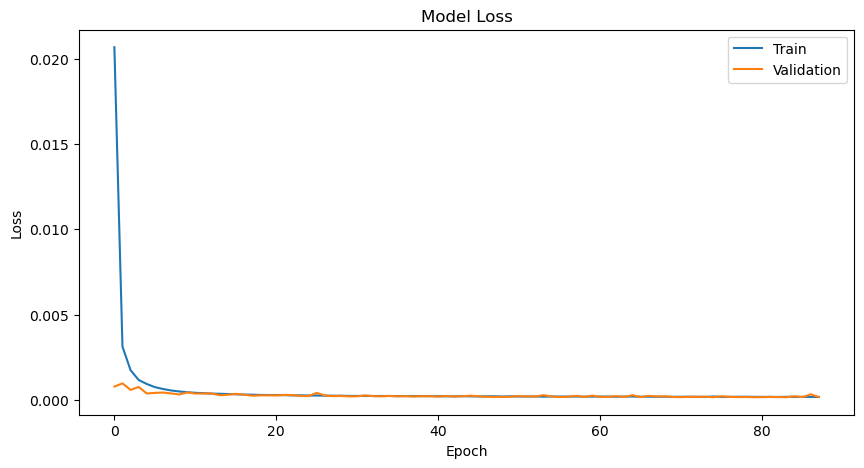

In [22]:
#Plot the training and validation loss

plt.figure(figsize=(10,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

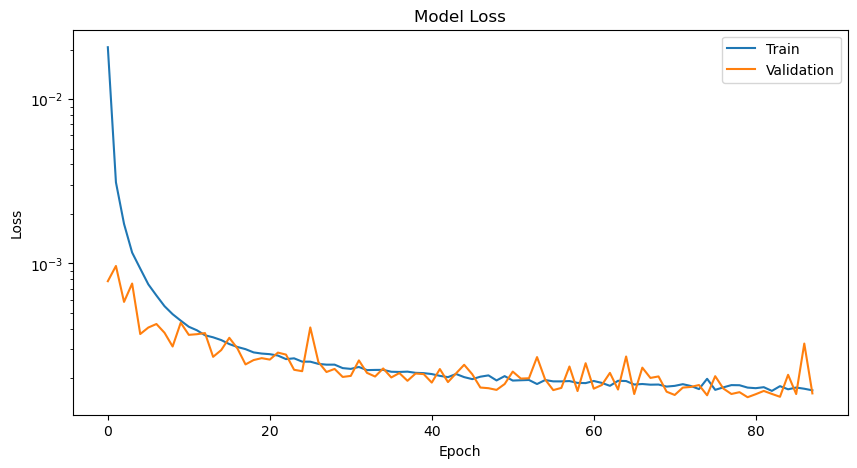

In [23]:
# Plot the training and validation loss on a logarithmic scale
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.yscale('log')  # Set the y-axis scale to logarithmic
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()


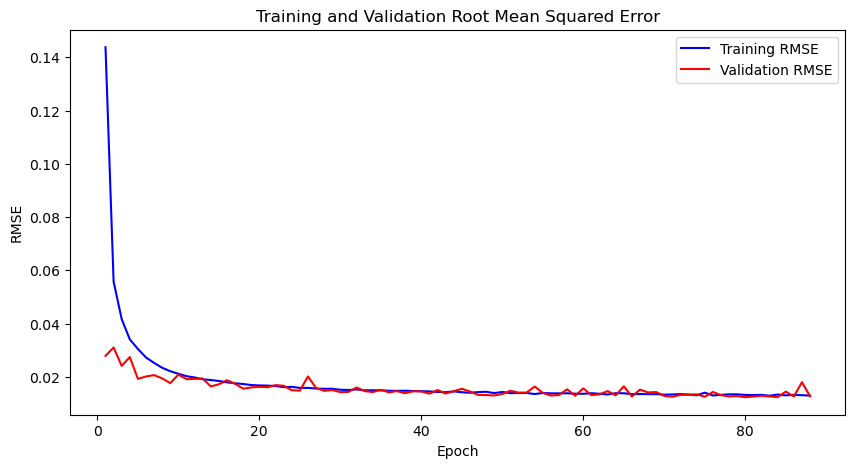

In [24]:
# Get the training and validation accuracy values from the history object
train_acc = history.history['root_mean_squared_error']
val_acc = history.history['val_root_mean_squared_error']

# Create a plot of training and validation accuracy
epochs = range(1, len(train_acc) + 1)
plt.figure(figsize=(10,5))
plt.plot(epochs, train_acc, 'b', label='Training RMSE')
plt.plot(epochs, val_acc, 'r', label='Validation RMSE')
plt.title('Training and Validation Root Mean Squared Error')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.legend()
plt.show()

In [25]:
# After training, print actual and predicted values for the validation data
y_val_pred = model.predict(X_val)
print("Actual\t\tPredicted")
for i in range(len(y_val)):
    print(f"{y_val[i]}\t{y_val_pred[i]}")

176/176 [==============================] - 2s 4ms/step
Actual		Predicted
[0.35826072]	[0.35613722]
[0.33700044]	[0.34068754]
[0.34828165]	[0.34923586]
[0.3806041]	[0.36583284]
[0.34185611]	[0.3374138]
[0.34488634]	[0.34351057]
[0.35778611]	[0.357683]
[0.34236723]	[0.35556442]
[0.31877282]	[0.3289257]
[0.34117461]	[0.33685657]
[0.35967239]	[0.36659575]
[0.3405783]	[0.34511507]
[0.37370394]	[0.34848487]
[0.28674001]	[0.27479047]
[0.35987928]	[0.35699165]
[0.34024972]	[0.34458256]
[0.35592416]	[0.34548765]
[0.34049311]	[0.34631014]
[0.3556686]	[0.35470384]
[0.3423794]	[0.34761938]
[0.33338607]	[0.33598223]
[0.34599377]	[0.35933018]
[0.33463954]	[0.3395141]
[0.35761573]	[0.36047685]
[0.34979068]	[0.34455067]
[0.38589787]	[0.40002075]
[0.34882928]	[0.35145122]
[0.34912136]	[0.3372043]
[0.33959256]	[0.34137127]
[0.33815655]	[0.34046596]
[0.33850947]	[0.33884308]
[0.35312515]	[0.35084316]
[0.35289393]	[0.35176325]
[0.38519204]	[0.3799174]
[0.33051404]	[0.32958436]
[0.34691866]	[0.34826663]
[0

[0.33093998]	[0.33520886]
[0.33467605]	[0.33589354]
[0.34172224]	[0.34486023]
[0.33619724]	[0.3375687]
[0.34854938]	[0.3546687]
[0.3565083]	[0.3764412]
[0.35931948]	[0.3524704]
[0.37083191]	[0.3748014]
[0.33504113]	[0.35271287]
[0.3312929]	[0.33634257]
[0.34366938]	[0.34048852]
[0.34538529]	[0.3501031]
[0.34263496]	[0.34838873]
[0.34491068]	[0.33821785]
[0.35552256]	[0.34693938]
[0.3581512]	[0.3512424]
[0.32491603]	[0.3428641]
[0.39753201]	[0.37709722]
[0.35767658]	[0.35579616]
[0.34341381]	[0.34242985]
[0.34680913]	[0.3477377]
[0.34749063]	[0.3451456]
[0.36761914]	[0.36587515]
[0.37170812]	[0.3641339]
[0.34179526]	[0.34558412]
[0.34087037]	[0.34117785]
[0.33422577]	[0.32623634]
[0.32980821]	[0.3209984]
[0.29280047]	[0.3084462]
[0.31985348]	[0.32523876]
[0.35406221]	[0.34908184]
[0.35119019]	[0.34435394]
[0.34374239]	[0.34593335]
[0.33230297]	[0.34094962]
[0.34904834]	[0.34683082]
[0.33076961]	[0.31901112]
[0.33425011]	[0.33410117]
[0.33910578]	[0.3406481]
[0.39042496]	[0.3691763]
[0.3

[0.35579029]	[0.34605935]
[0.35541304]	[0.3554057]
[0.34280534]	[0.34595394]
[0.39941829]	[0.37900302]
[0.3919705]	[0.36963412]
[0.33224213]	[0.33914176]
[0.33359295]	[0.33911633]
[0.35755488]	[0.34985283]
[0.31202843]	[0.3282424]
[0.32679015]	[0.3424132]
[0.34593292]	[0.3388948]
[0.3645524]	[0.3494845]
[0.35816336]	[0.35110942]
[0.34317042]	[0.3390601]
[0.36472278]	[0.34909016]
[0.3493039]	[0.35387075]
[0.34264713]	[0.33895847]
[0.34833033]	[0.34771472]
[0.35156744]	[0.356677]
[0.3569099]	[0.35793418]
[0.35530351]	[0.35683784]
[0.34456993]	[0.35588685]
[0.34616414]	[0.34178317]
[0.36299469]	[0.34702703]
[0.32771504]	[0.32593977]
[0.35273573]	[0.36280105]
[0.28081342]	[0.26744542]
[0.35283308]	[0.3464403]
[0.36238621]	[0.3723353]
[0.28562041]	[0.31606966]
[0.33903276]	[0.3431244]
[0.3320109]	[0.30810577]
[0.3811639]	[0.3691438]
[0.3425011]	[0.34616202]
[0.30224407]	[0.32826027]
[0.3357348]	[0.3370059]
[0.35171348]	[0.33952653]
[0.32233608]	[0.33798367]
[0.33802268]	[0.33997002]
[0.3435

[0.33143893]	[0.3250341]
[0.34403446]	[0.3590801]
[0.33861899]	[0.34054112]
[0.32138685]	[0.3350822]
[0.34560434]	[0.3451807]
[0.33650148]	[0.33724836]
[0.35341722]	[0.36831772]
[0.35581463]	[0.35322064]
[0.34516624]	[0.34641054]
[0.32578007]	[0.32770407]
[0.37064937]	[0.366148]
[0.30652777]	[0.29388493]
[0.35227328]	[0.3156095]
[0.35736017]	[0.36887106]
[0.34847637]	[0.3453717]
[0.32158156]	[0.33743986]
[0.33518717]	[0.33790743]
[0.32100959]	[0.3240419]
[0.36909166]	[0.35422876]
[0.34038359]	[0.34697887]
[0.34909702]	[0.3445732]
[0.40065959]	[0.39132708]
[0.35812686]	[0.37276235]
[0.34851288]	[0.35344774]
[0.33507764]	[0.34080184]
[0.3674366]	[0.35611856]
[0.33379983]	[0.34060058]
[0.37593097]	[0.37070638]
[0.32906586]	[0.34217548]
[0.35460984]	[0.35180494]
[0.34624933]	[0.33892718]
[0.34953512]	[0.3455336]
[0.36283649]	[0.35451913]
[0.34665093]	[0.35965392]
[0.3523463]	[0.35453603]
[0.32435623]	[0.33851963]
[0.35347807]	[0.35693648]
[0.36896997]	[0.36694923]
[0.32871294]	[0.33464485]

In [26]:
y_val.shape

(5606, 1)

In [27]:
y_val_pred.shape

(5606, 1)

In [28]:
# Define the minimum and maximum values of the original data
min_price = df_powerprice["Spot"].min()
max_price = df_powerprice["Spot"].max()

# Inverse transform the scaled actual values (y_val)
y_val_original = (y_val * (max_price - min_price)) + min_price

# Inverse transform the scaled predicted values (y_val_pred)
y_val_pred_original = (y_val_pred * (max_price - min_price)) + min_price

# Print the original actual and predicted values
print("Actual\t\tPredicted")
for i in range(len(y_val_original)):
    actual = y_val_original[i]
    predicted = y_val_pred_original[i]
    print(f"{actual}\t{predicted}")

Actual		Predicted
[4.992]	[4.817505]
[3.245]	[3.5479755]
[4.172]	[4.250408]
[6.828]	[5.614214]
[3.644]	[3.278965]
[3.893]	[3.7799492]
[4.953]	[4.9445267]
[3.686]	[4.7704372]
[1.7472]	[2.581482]
[3.588]	[3.2331772]
[5.108]	[5.6769047]
[3.539]	[3.9117928]
[6.261]	[4.188698]
[-0.885]	[-1.8669186]
[5.125]	[4.8877163]
[3.512]	[3.8680363]
[4.8]	[3.9424095]
[3.532]	[4.0099945]
[4.779]	[4.6997223]
[3.687]	[4.1175785]
[2.948]	[3.1613312]
[3.984]	[5.079878]
[3.051]	[3.4515514]
[4.939]	[5.174103]
[4.296]	[3.8654156]
[7.263]	[8.423502]
[4.217]	[4.4324474]
[4.241]	[3.2617512]
[3.458]	[3.6041584]
[3.34]	[3.529768]
[3.369]	[3.396412]
[4.57]	[4.3824825]
[4.551]	[4.458088]
[7.205]	[6.771572]
[2.712]	[2.6356049]
[4.06]	[4.170765]
[4.24]	[3.573574]
[3.256]	[3.5271473]
[3.788]	[4.595232]
[3.844]	[3.5368595]
[4.43]	[3.7509937]
[3.633]	[4.129219]
[-0.732]	[0.11540985]
[4.152]	[2.741129]
[3.577]	[2.6538486]
[4.421]	[5.6732674]
[4.124]	[4.0027237]
[1.715]	[3.1848812]
[5.567]	[3.842268]
[3.673]	[3.9358387]
[3.

[3.905]	[4.0502605]
[4.456]	[4.2183704]
[6.061]	[5.4672318]
[3.688]	[3.5020523]
[5.61]	[4.5192795]
[3.425]	[3.2375412]
[3.076]	[3.5333633]
[2.324]	[1.526123]
[3.464]	[3.646885]
[4.498]	[3.6418247]
[4.314]	[3.9813728]
[5.699]	[5.712538]
[4.951]	[5.2623825]
[1.938]	[2.072466]
[2.628]	[3.1475868]
[4.798]	[4.818424]
[4.484]	[4.952837]
[3.813]	[3.6078396]
[4.328]	[4.8902664]
[2.747]	[3.0977821]
[3.054]	[3.1540432]
[3.633]	[3.890854]
[3.179]	[3.2916946]
[4.194]	[4.6968346]
[4.848]	[6.4859257]
[5.079]	[4.5161953]
[6.025]	[6.351179]
[3.084]	[4.5361195]
[2.776]	[3.1909409]
[3.793]	[3.531622]
[3.934]	[4.3216705]
[3.708]	[4.1807976]
[3.895]	[3.3450356]
[4.767]	[4.061701]
[4.983]	[4.415289]
[2.252]	[3.7268276]
[8.219]	[6.539831]
[4.944]	[4.78948]
[3.772]	[3.691143]
[4.051]	[4.1273003]
[4.107]	[3.9143047]
[5.761]	[5.617691]
[6.097]	[5.4746094]
[3.639]	[3.9503365]
[3.563]	[3.5882645]
[3.017]	[2.3604908]
[2.654]	[1.9300785]
[-0.387]	[0.8986397]
[1.836]	[2.2785187]
[4.647]	[4.237751]
[4.411]	[3.849250

[4.044]	[4.213505]
[5.929]	[5.9146004]
[7.544]	[6.9088917]
[4.401]	[4.5781765]
[4.428]	[3.4641857]
[2.862]	[3.276804]
[2.098]	[2.9223194]
[4.231]	[4.818186]
[4.135]	[4.668827]
[2.82]	[3.1294365]
[2.889]	[3.5524426]
[2.537]	[2.919241]
[4.016]	[4.868494]
[7.225]	[6.16053]
[1.674]	[0.887167]
[0.473]	[-0.04595184]
[4.345]	[4.930729]
[4.805]	[5.0968094]
[9.489]	[8.711336]
[3.479]	[3.4201565]
[3.872]	[4.493183]
[0.891]	[3.2894459]
[4.391]	[4.4554768]
[4.12]	[4.728916]
[2.789]	[3.1922264]
[3.501]	[3.5076542]
[2.788]	[3.5223923]
[3.284]	[3.3041878]
[3.109]	[3.5440083]
[5.339]	[6.2686043]
[3.396]	[3.4308586]
[3.921]	[3.3899117]
[5.473]	[5.6488914]
[1.428]	[2.171358]
[3.958]	[3.922268]
[2.864]	[3.2408257]
[3.618]	[3.5643654]
[2.913]	[3.5035152]
[4.349]	[4.57568]
[4.208]	[3.934206]
[5.148]	[6.542473]
[4.658]	[4.749487]
[5.032]	[5.831476]
[5.755]	[5.220022]
[4.716]	[3.9546185]
[3.455]	[3.5635471]
[3.885]	[4.2565823]
[6.764]	[6.344507]
[3.529]	[4.595377]
[2.493]	[1.945715]
[2.475]	[1.5402431]
[-1.4

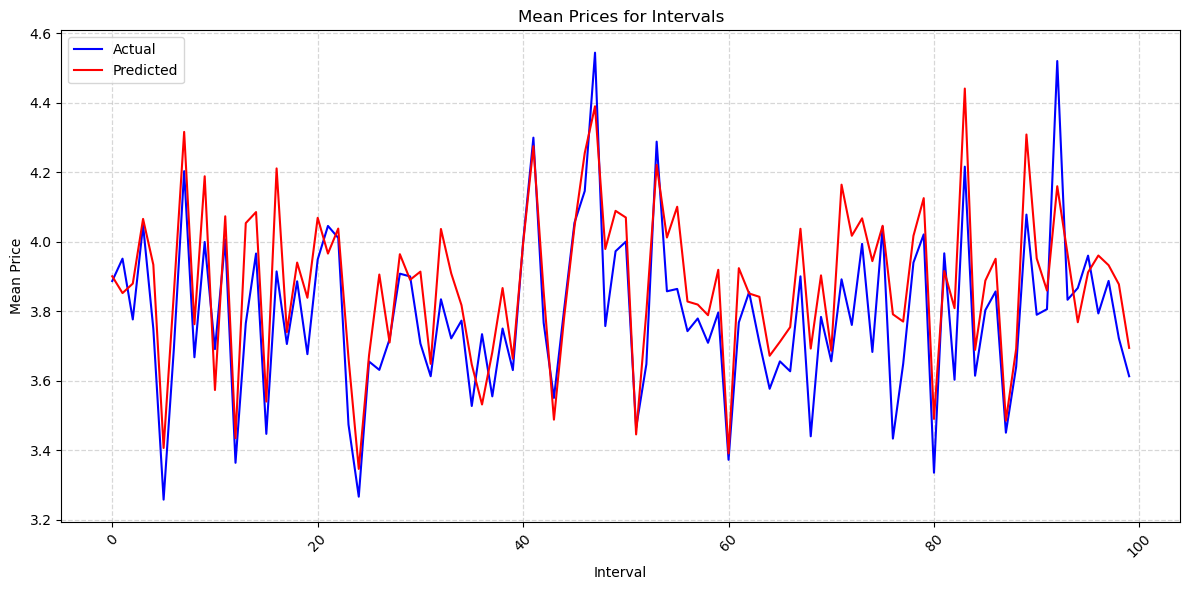

In [29]:
# Define the number of intervals
num_intervals = 100

# Calculate the interval size
interval_size = len(y_val_original) // num_intervals

# Calculate the means for each interval
interval_means_actual = [np.mean(y_val_original[i * interval_size:(i + 1) * interval_size]) for i in range(num_intervals)]
interval_means_pred = [np.mean(y_val_pred_original[i * interval_size:(i + 1) * interval_size]) for i in range(num_intervals)]

# Generate x-axis values for the intervals
x_values = np.arange(num_intervals)

# Plotting the interval means
plt.figure(figsize=(12, 6))
plt.plot(x_values, interval_means_actual, label='Actual', color='blue')
plt.plot(x_values, interval_means_pred, label='Predicted', color='red')
plt.xlabel('Interval')
plt.ylabel('Mean Price')
plt.title('Mean Prices for Intervals')
plt.legend()

# Customize the appearance of the plot
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', linewidth=0.9, alpha=0.5)

plt.tight_layout()
plt.show()